## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import kagglehub
import os
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
from email.utils import parsedate_to_datetime
from collections import defaultdict
from nltk.tokenize import sent_tokenize
import random
import quopri

In [ ]:
path = kagglehub.dataset_download("wcukierski/enron-email-dataset")
df = pd.read_csv(path + "/emails.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
employees_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/employees_enron.csv', sep=';')

## Define and Apply Categorization Rules

In [ ]:
# Define the categorization rules
def categorize_level(row):
    job_title = str(row['Job_Title']).strip().lower() if pd.notna(row['Job_Title']) else ""
    department = str(row['Department']).strip().lower() if pd.notna(row['Department']) else ""

    # High level positions (exact matches)
    high_positions = [
        'ceo',
        'president & ceo',
        'president & coo',
        'evp & general counsel',
        'evp & cro',
        'managing director & cco',
        'managing director',
        'coo',
        'president'  # Standalone president
    ]

    # Medium level positions
    medium_positions = [
        'vice president',
        'vice president & general counsel',
        'vp & assistant general counsel',
        'director',
        'manager'
    ]

    # First check for exact matches in high level
    if any(job_title == pos.lower() for pos in high_positions):
        return 'High'

    # Then check for exact matches in medium level
    elif any(job_title == pos.lower() for pos in medium_positions):
        return 'Medium'

    # Special case for Attorneys
    elif 'attorney' in job_title:
        if 'general counsel' in department or 'assistant general counsel' in department:
            return 'Medium'
        else:
            return 'Low'

    # Low level positions (default)
    else:
        return 'Low'

# Apply the categorization
employees_df['Level'] = employees_df.apply(categorize_level, axis=1)
employees_df['First_Name'] = employees_df['First_Name'].str.capitalize()
employees_df['Last_Name'] = employees_df['Last_Name'].str.capitalize()
print(employees_df.head(5))

  First_Name Last_Name          Job_Title Department   Level
0    Phillip     Allen  Managing Director        NaN    High
1       John    Arnold     Vice President    Trading  Medium
2      Harry     Arora     Vice President        NaN  Medium
3     Robert    Badeer            Manager        NaN  Medium
4      Susan    Bailey           Attorney        NaN     Low


## Cleaning and Preparing the Dataset

### Parse Emails

In [ ]:
def parse_email(text):
    fields = {
        'Message-ID': '',
        'Date': '',
        'From': '',
        'To': '',
        'Subject': '',
        'Body': ''
    }

    # Extract using regex
    headers = {
        'Message-ID': re.search(r'Message-ID:\s*(.+)', text),
        'Date': re.search(r'Date:\s*(.+)', text),
        'From': re.search(r'From:\s*(.+)', text),
        'To': re.search(r'To:\s*(.+)', text),
        'Subject': re.search(r'Subject:\s*(.+)', text),
    }

    for key, match in headers.items():
        if match:
            fields[key] = match.group(1).strip()

    body_split = re.split(r'\n\s*\n', text, maxsplit=1)
    if len(body_split) > 1:
        fields['Body'] = body_split[1].strip()

    return pd.Series(fields)

df_parsed = df['message'].apply(parse_email)
df_final = pd.concat([df, df_parsed], axis=1)

In [ ]:
df_final.head()

,file,message,Message-ID,Date,From,To,Subject,Body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.


### Filter by Date Range

In [ ]:
df_final['Date'] = pd.to_datetime(df_final['Date'], errors='coerce', utc = True)
print(df_final['Date'].dtype)

<ipython-input-52-285633339>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final['Date'] = pd.to_datetime(df_final['Date'], errors='coerce', utc = True)


datetime64[ns, UTC]


In [ ]:
start_date = '1998-01-01'
end_date   = '2004-12-31'

mask = (df_final['Date'] >= start_date) & (df_final['Date'] <= end_date)
df_final = df_final.loc[mask].reset_index(drop=True)

### Filter Allowed Email Domains

In [ ]:
allowed_domains = ['@enron', '@yahoo', '@hotmail', '@outlook']

#keeping only rows with valid domains
df_final = df_final[df_final['From'].str.contains('|'.join(allowed_domains), na=False)]

### Extract Sender/Recipient Names

In [ ]:
# Extract name and surname from the email checking for all the possible patterns
def extract_name_surname(email, known_names, known_surnames):
    email_prefix = email.split('@')[0].lower()

    def clean(part):
        return re.sub(r'\d+', '', part)

    # Split by dot or underscore ignoring empty parts
    if '.' in email_prefix:
        parts = [clean(p) for p in email_prefix.split('.') if p.strip()]
        if len(parts) == 2:
            part1, part2 = parts

            # Handle initial case: if part1 is single char initial
            if len(part1) == 1:
                # Try to find full first name by surname (part2)
                matches = employees_df[employees_df['Last_Name'].str.lower() == part2]
                if len(matches) == 1:
                    return matches['First_Name'].values[0].capitalize(), part2.capitalize()
                else:
                    return part1.upper(), part2.capitalize()

            part1_is_name = part1.capitalize() in known_names.values
            part2_is_surname = part2.capitalize() in known_surnames.values
            part2_is_name = part2.capitalize() in known_names.values
            part1_is_surname = part1.capitalize() in known_surnames.values

            if part1_is_name and part2_is_surname:
                return part1.capitalize(), part2.capitalize()
            elif part2_is_name and part1_is_surname:
                return part2.capitalize(), part1.capitalize()
            else:
                return part1.capitalize(), part2.capitalize()
        elif len(parts) == 3:
            first, last = clean(parts[0]), clean(parts[2])
            if len(first) == 1:
                # Try to find full first name by surname (part2)
                matches = employees_df[employees_df['Last_Name'].str.lower() == last]
                if len(matches) == 1:
                    return matches['First_Name'].values[0].capitalize(), last.capitalize()
                else:
                    return first.upper(), last.capitalize()

            part1_is_name = first.capitalize() in known_names.values
            part2_is_surname = last.capitalize() in known_surnames.values
            part2_is_name = last.capitalize() in known_names.values
            part1_is_surname = first.capitalize() in known_surnames.values

            if part1_is_name and part2_is_surname:
                return first.capitalize(), last.capitalize()
            elif part2_is_name and part1_is_surname:
                return last.capitalize(), first.capitalize()
            else:
                return first.capitalize(), last.capitalize()

    elif '_' in email_prefix:
        parts = [clean(p) for p in email_prefix.split('_') if p.strip()]
        if len(parts) == 2:
            part1, part2 = parts

            if len(part1) == 1:
                matches = employees_df[employees_df['Last_Name'].str.lower() == part2]
                if len(matches) == 1:
                    return matches['First_Name'].values[0].capitalize(), part2.capitalize()
                else:
                    return part1.upper(), part2.capitalize()

            part1_is_name = part1.capitalize() in known_names.values
            part2_is_surname = part2.capitalize() in known_surnames.values
            part2_is_name = part2.capitalize() in known_names.values
            part1_is_surname = part1.capitalize() in known_surnames.values

            if part1_is_name and part2_is_surname:
                return part1.capitalize(), part2.capitalize()
            elif part2_is_name and part1_is_surname:
                return part2.capitalize(), part1.capitalize()
            else:
                return part1.capitalize(), part2.capitalize()

    pattern = re.compile(r'([a-z]+)\d*([a-z]+)')
    match = pattern.match(email_prefix)
    if match:
        first, last = match.groups()
        if first in known_names.values and last in known_surnames.values:
            return first.capitalize(), last.capitalize()

    found_name = next((name for name in known_names if name.lower() in email_prefix), None)
    found_surname = next((surname for surname in known_surnames if surname.lower() in email_prefix), None)

    if found_name and not found_surname:
        matches = employees_df[employees_df['First_Name'].str.lower() == found_name.lower()]
        if len(matches) == 1:
            return found_name.capitalize(), matches['Last_Name'].values[0].capitalize()
        else:
            return found_name.capitalize(), 'Unknown'

    if found_surname and not found_name:
        matches = employees_df[employees_df['Last_Name'].str.lower() == found_surname.lower()]
        if len(matches) == 1:
            return matches['First_Name'].values[0].capitalize(), found_surname.capitalize()
        else:
            return 'Unknown', found_surname.capitalize()

    if found_name and found_surname:
        return found_name.capitalize(), found_surname.capitalize()

    return 'Unknown', 'Unknown'

known_names = employees_df['First_Name']
known_surnames = employees_df['Last_Name']
first_names, last_names, mails = [], [], []
for mail in df_final['From']:
    first, last = extract_name_surname(mail, known_names, known_surnames)
    first_names.append(first)
    last_names.append(last)
    if pd.notnull(mail) and '@' in mail:
        mails.append(mail.split('@')[1])
    else:
        mails.append('Unknown')
df_final['From_First_Name'] = first_names
df_final['From_Last_Name'] = last_names
df_final['From_Mail'] = mails
df_final['From_External'] = df_final['From_Mail'].apply(lambda x: 'enron.com' not in x)

first_names, last_names, mails = [], [], []
for mail in df_final['To']:
    first, last = extract_name_surname(mail, known_names, known_surnames)
    first_names.append(first)
    last_names.append(last)
    if pd.notnull(mail) and '@' in mail:
        mails.append(mail.split('@')[1])
    else:
        mails.append('Unknown')
df_final['To_First_Name'] = first_names
df_final['To_Last_Name'] = last_names
df_final['To_Mail'] = mails
df_final['To_External'] = df_final['To_Mail'].apply(lambda x: 'enron.com' not in x)

In [ ]:
# Merge with employee data
df_final = df_final.merge(employees_df,
                         left_on=['From_First_Name', 'From_Last_Name'],
                         right_on=['First_Name', 'Last_Name'],
                         how='left')
df_final.drop(columns=['First_Name', 'Last_Name', 'Job_Title', 'Department'])

,file,message,Message-ID,Date,From,To,Subject,Body,From_First_Name,From_Last_Name,From_Mail,From_External,To_First_Name,To_Last_Name,To_Mail,To_External,Level
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00+00:00,phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast,Phillip,Allen,enron.com,False,Tim,Belden,enron.com,False,High
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00+00:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,Phillip,Allen,enron.com,False,John,Lavorato,enron.com,False,High
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00+00:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,Phillip,Allen,enron.com,False,Leah,Arsdall,enron.com,False,High
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00+00:00,phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s...",Phillip,Allen,enron.com,False,Randall,Gay,enron.com,False,High
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00+00:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,Phillip,Allen,enron.com,False,Greg,Piper,enron.com,False,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430915,zufferli-j/sent_items/95.,Message-ID: <26807948.1075842029936.JavaMail.e...,<26807948.1075842029936.JavaMail.evans@thyme>,2001-11-28 21:30:11+00:00,john.zufferli@enron.com,kori.loibl@enron.com,Trade with John Lavorato,This is a trade with OIL-SPEC-HEDGE-NG (John L...,John,Zufferli,enron.com,False,Kori,Loibl,enron.com,False,Medium
430916,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...,<25835861.1075842029959.JavaMail.evans@thyme>,2001-11-28 20:47:48+00:00,john.zufferli@enron.com,john.lavorato@enron.com,Gas Hedges,Some of my position is with the Alberta Term b...,John,Zufferli,enron.com,False,John,Lavorato,enron.com,False,Medium
430917,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...,<28979867.1075842029988.JavaMail.evans@thyme>,2001-11-28 15:20:00+00:00,john.zufferli@enron.com,dawn.doucet@enron.com,RE: CONFIDENTIAL,2\n\n -----Original Message-----\nFrom: \tDouc...,John,Zufferli,enron.com,False,Dawn,Doucet,enron.com,False,Medium
430918,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...,<22052556.1075842030013.JavaMail.evans@thyme>,2001-11-27 19:52:45+00:00,john.zufferli@enron.com,jeanie.slone@enron.com,Calgary Analyst/Associate,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...,John,Zufferli,enron.com,False,Jeanie,Slone,enron.com,False,Medium


In [ ]:
df_final.loc[(df_final['Level'].isna()) & (df_final['From'].str.contains('@enron.com'))].groupby('From').agg(n_mail=('From', 'count')).sort_values('n_mail', ascending=False).head(60)

,n_mail
From,
enron.announcements@enron.com,8587
no.address@enron.com,5112
40enron@enron.com,2435
outlook.team@enron.com,1785
announcements.enron@enron.com,1195
office.chairman@enron.com,879
perfmgmt@enron.com,830
houston <.ward@enron.com>,708
bill.iii@enron.com,612


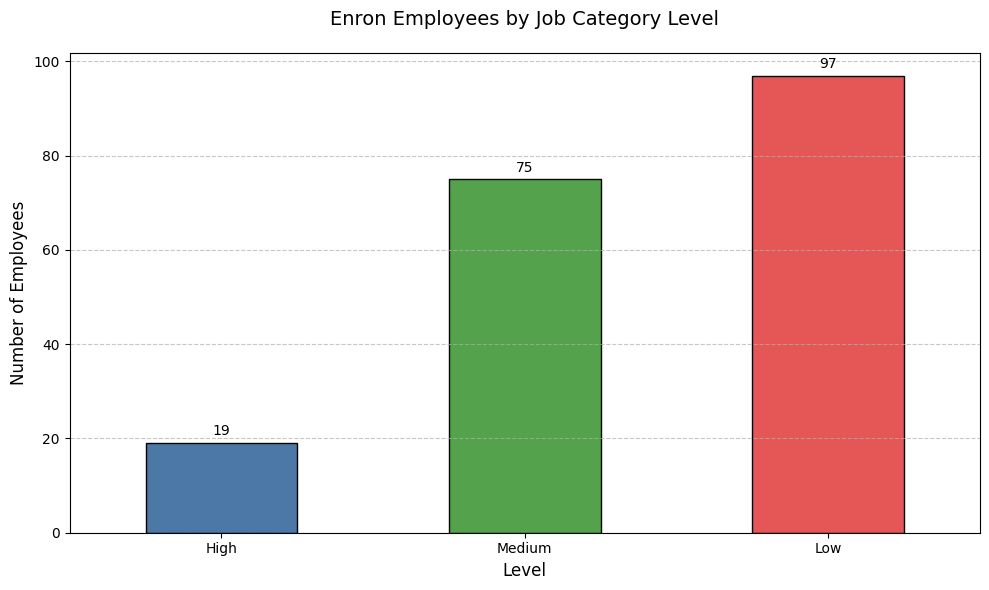

In [ ]:
#visualization of the category division
counts = employees_df["Level"].value_counts().reindex(["High", "Medium", "Low"])

#bar chart
plt.figure(figsize=(10, 6))
bars = counts.plot(kind="bar", color=["#4C78A8", "#54A24B", "#E45756", "#79706E"], edgecolor="black")

plt.title("Enron Employees by Job Category Level", fontsize=14, pad=20)
plt.xlabel("Level", fontsize=12)
plt.ylabel("Number of Employees", fontsize=12)
plt.xticks(rotation=0)

for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{int(bar.get_height())}",
        ha="center",
        va="bottom",
        fontsize=10
    )
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
df_final.head()

,file,message,Message-ID,Date,From,To,Subject,Body,From_First_Name,From_Last_Name,...,From_External,To_First_Name,To_Last_Name,To_Mail,To_External,First_Name,Last_Name,Job_Title,Department,Level
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00+00:00,phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast,Phillip,Allen,...,False,Tim,Belden,enron.com,False,Phillip,Allen,Managing Director,NaN,High
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00+00:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,Phillip,Allen,...,False,John,Lavorato,enron.com,False,Phillip,Allen,Managing Director,NaN,High
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00+00:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,Phillip,Allen,...,False,Leah,Arsdall,enron.com,False,Phillip,Allen,Managing Director,NaN,High
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00+00:00,phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s...",Phillip,Allen,...,False,Randall,Gay,enron.com,False,Phillip,Allen,Managing Director,NaN,High
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00+00:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,Phillip,Allen,...,False,Greg,Piper,enron.com,False,Phillip,Allen,Managing Director,NaN,High


## Cleaning Email Body

### Non-Text and Paragraph Normalization

In [ ]:
def remove_signature_block(text, min_signals=3):
    signature_keywords = [
        #r'@',
        r'fax\b', r'phone\b', r'mobile\b', r'tel\b',
        r'street\b', r'avenue\b', r'floor\b', r'suite\b',
        r'houston', r'tx\b', r'enron\b', r'corp\b', r'company\b',
        r'(director|manager|assistant|specialist|executive|coordinator)',
        r'\d{3}[-/\.\s]?\d{3}[-/\.\s]?\d{4}',
        r'\(\d{3}\)\s*\d{3}-\d{4}',
        r'https?://', r'www\.',
        r'\.com\b', r'\.org\b', r'\.edu\b'
    ]

    lines = text.strip().split('\n')
    # Start from the bottom and collect a block with no blank lines
    block = []
    for line in reversed(lines):
        if not line.strip():  # Empty line -> stop block
            break
        block.insert(0, line)

    # Evaluate the block
    signal_count = sum(
        any(re.search(pat, line, re.IGNORECASE) for pat in signature_keywords)
        for line in block
        if line.strip()
    )

    if signal_count >= min_signals:
        return "\n".join(lines[:-len(block)]).strip()

    return text.strip()

In [ ]:
def remove_reply_block(text):
    lines = text.splitlines()
    for i, line in enumerate(lines):
        if re.match(r'^\s*(to|cc|bcc|subject):', line, re.IGNORECASE):
            return "\n".join(lines[:i]).strip()
    return text

In [ ]:
def decode_quoted_printable(text):
    return quopri.decodestring(text).decode('utf-8', errors='ignore')


In [ ]:
def remove_short_closing_signature(text):
    lines = text.strip().split('\n')
    if not lines:
        return text

    # checks last 2 non empy lines
    non_empty_lines = [line.strip() for line in lines if line.strip()]
    if len(non_empty_lines) == 0:
        return text

    last_line = non_empty_lines[-1]

    # Signature on separate line after . , or ?
    if len(non_empty_lines) >= 2:
        second_last_line = non_empty_lines[-2]
        if re.fullmatch(r'([A-Z][a-z]+|[A-Z]{1,2})( [A-Z][a-z]+)?', last_line.strip()) and re.search(r'[.,?!]\s*$', second_last_line):
            return '\n'.join(lines[:-1]).strip()

    # Signature on same line after . , or ?
    if re.search(r'[.,?!]\s+([A-Z][a-z]+(?: [A-Z][a-z]+)?|[A-Z]{1,2})$', last_line):
        match = re.search(r'^(.*?[.,?!])\s+([A-Z][a-z]+(?: [A-Z][a-z]+)?|[A-Z]{1,2})$', last_line)
        if match:
            new_last_line = match.group(1)
            for i in range(len(lines) - 1, -1, -1):
                if lines[i].strip() == last_line:
                    return '\n'.join(lines[:i] + [new_last_line]).strip()


    return text


In [ ]:
def remove_confidentiality_disclaimer(text):
    disclaimer_keywords = [
        "privileged", "confidential", "confidentiality notice", "not the intended recipient",
        "received in error", "please delete", "dissemination", "unauthorized",
        "review", "joint defense agreement", "legal disclaimer", "thank you"
    ]

    # Split into lines and search near the end
    lines = text.strip().splitlines()
    start = max(0, len(lines) - 15)  # look only at last 15 lines
    tail = lines[start:]

    block = "\n".join(tail).lower()
    keyword_hits = sum(1 for kw in disclaimer_keywords if kw in block)

    if keyword_hits >= 3 and len(block) > 300:
        # Remove all text from the first disclaimer keyword hit to end
        for i, line in enumerate(tail):
            if any(kw in line.lower() for kw in disclaimer_keywords):
                return "\n".join(lines[:start + i]).strip()

    return text.strip()


In [ ]:
def clean_email_body(text):
    if not isinstance(text, str):
        return ""

    # Removes lines that start with >
    text = '\n'.join(line for line in text.splitlines() if not line.strip().startswith('>'))

    # Removes lines like [date][name] wrote:"
    text = re.sub(r'^On \d{1,2}/\d{1,2}/\d{2,4} .{1,50}? wrote:\s*$', '', text, flags=re.MULTILINE)

    # Removes everything from "Forwarded by" or "Original Message"
    text = re.split(r'(?im)^[-\s]*\b(forwarded by|original message)\b.*', text, maxsplit=1)[0]

    # removes reply blocks (To:, Cc:, Subject: ecc.)
    text = remove_reply_block(text)

    # Removes signature blocks
    text = remove_signature_block(text)

    # Removes attachments
    text = re.sub(r'\b[\w\-]+\.(pdf|docx?|xlsx?|csv|json|pptx?|txt|zip|jpg|pcx)\b', '', text, flags=re.IGNORECASE)

    # Decode content encoded in quoted-printable
    text = decode_quoted_printable(text)

    # Removes links
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Removes disclaimers
    text = remove_confidentiality_disclaimer(text) #check

    # Removs timestamps
    text = re.sub(r'^\s*\d{2}/\d{2}/\d{4} \d{2}:\d{2} [AP]M\s*$', '', text, flags=re.MULTILINE)

    # Removes emails within <>
    text = re.sub(r'^.*<[^@<>\s]+@[^<>\s]+>.*$\n?', '', text, flags=re.MULTILINE) #check

    # Removes lines with emails @ENRON o @ECT
    text = re.sub(r'^[ \t]*[A-Za-z]+(?: [A-Za-z]+)*@(ENRON|ECT)[ \t]*\n?', '', text, flags=re.MULTILINE)

    # Removes IMAGE
    text = re.sub(r'\bIMAGE\b', '', text)

    # Removes all non-text characters except punctuation
    text = re.sub(r"[^a-zA-Z.,!?;:'\"()\n ]+", "", text)

    # Removes empty parenthesis or paranthesis that contain something other than letters
    text = re.sub(r'\(\s*[^\w\s]*\s*\)', '', text)

    # Removes lines starting with "From:" or "Sent by:"
    text = re.sub(r'^\s*(From|Sent by):\s+.*$', '', text, flags=re.MULTILINE)

    # Removes short signatures
    text = remove_short_closing_signature(text)

    # Removes multiple empty lines
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'[ \t]+', ' ', text)


    return text.strip()


In [ ]:
df_filtered = df_final.loc[df_final['Level'].notna()].copy()

In [ ]:
df_filtered['Cleaned_Body'] = df_filtered['Body'].apply(clean_email_body)

### Sentence Normalization

In [ ]:
# Sentence Normalization

def sentence_normalization(text):
    if not isinstance(text, str):
        return ""

    # Handle \n and cleanup
    text_repr = repr(text).strip("'\"")

    # Special rule: replace comma with dot if first line has one word ending with comma
    first_line = text_repr.split('\\n')[0]
    if re.match(r'^[A-Za-z]+[,]$', first_line.strip()):
        text_repr = text_repr.replace(first_line, first_line.replace(',', '.'), 1)

    # Replace any word ending in : with a .
    text_repr = re.sub(r'(\w+):', r'\1.', text_repr)

    # Remove space(s) before a period (e.g., "word  ." → "word.")
    text_repr = re.sub(r'\s+\.', '.', text_repr)

    # Add punctuation before \n if missing
    text_repr = re.sub(r'(?<![.!?,])\\n(?=[A-Z])', r'.\\n', text_repr)

    # Flatten and clean lines
    parts = text_repr.split('\\n')
    text = ' '.join(p.strip() for p in parts if p.strip())

    # Normalize repeated punctuation
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'!{2,}', '!', text)
    text = re.sub(r'\?{2,}', '?', text)

    # Add space after punctuation if missing
    text = re.sub(r'([.!?])([^\s"\'])', r'\1 \2', text)

    # Sentence splitting and filtering
    sentences = re.split(r'(?<=[.!?])\s+', text)
    sentences = [s.strip() for s in sentences if len(s.strip()) > 2 and any(c.isalpha() for c in s)]

    return ' '.join(sentences)


In [ ]:
df_filtered['Cleaned_Body_n'] = df_filtered['Cleaned_Body'].apply(sentence_normalization)

### Word Normalization

In [ ]:
# Word normalization

acronyms = {"CEO", "CFO", "IBM", "SEC", "ENRON", "FBI", "IRS", "USA", "Nokia"}

def restore_case_minimal(text, acronyms=acronyms):
    if not isinstance(text, str):
        return ""

    words = text.split()
    result = []
    capitalize_next = True

    for word in words:
        base = word.strip('.,!?')  # remove trailing punctuation

        if not base:
            result.append(word)
            capitalize_next = word.endswith('.') or word.endswith('!') or word.endswith('?')
            continue

        # Handle acronyms and capitalization after punctuation
        if base.upper() in acronyms:
            fixed = base.upper()
        elif capitalize_next and not base[0].isupper():
            fixed = base.capitalize()
        else:
            fixed = base

        suffix = word[len(base):]  # restore punctuation
        result.append(fixed + suffix)

        capitalize_next = word.endswith('.') or word.endswith('!') or word.endswith('?')

    return ' '.join(result)


In [ ]:
df_filtered['Cleaned_Body_n'] = df_filtered['Cleaned_Body_n'].apply(restore_case_minimal)

In [ ]:
emails_to_remove = [
    'ibuyit@enron.com', 'getmorechannels@hotmail.com', 'cluwhite@hotmail.com',
    'enron.general.announcements.enronxgate@enron.com',
    'gary.allen.-.safety.specialist@enron.com', 'budanski@hotmail.com',
    'maggiemschf@yahoo.com', 'getmorechannels2@hotmail.com',
    'alerts-breakingnews@yahoo-inc.com', 'malanga45@yahoo.com',
    'alltimeqb@hotmail.com', 'lizard6849@yahoo.com', 'buy@enron.com',
    'black@enron.com', 'zipper@enron.com', 'neale@enron.com'
]

# Rimuovi le righe in cui il campo 'From' è in emails_to_remove
df_filtered = df_filtered[~df_filtered['From'].isin(emails_to_remove)]


In [ ]:
len(df_filtered)

267774

In [ ]:
df_filtered['From'].nunique()

467

## Saving the Dataset

In [ ]:
df_filtered.to_csv('/content/drive/MyDrive/NLP_Project/df_clean.csv', sep='§')